In [1]:
from standardInclude import *
from fit_util import *
from omega_a_fitting import *
from pileup_correction import *
from lost_muon_calculation import *

Welcome to JupyROOT 6.12/06
For interactive plots, run: setint()
To return to non-interactive plots (default state), run: noint()


### Notebook to do the fits to the 60h histograms the analyzers have sent

---

In [2]:
with open('param_dict.txt','r') as inf:
    anal_dict = eval(inf.read())
print(anal_dict)
    
analyses = anal_dict['analyses']
requiredParams = anal_dict['requiredParams']
colors = anal_dict['colors']
startTime = anal_dict['startTime']
endTime = anal_dict['endTime']

{'requiredParams': 9, 'colors': [1, 2, 3, 4, 6, 7, 9], 'startTime': 30.19, 'endTime': 650.07445, 'energyThreshold': 1710.0, 'analyses': [['Aaron', './data/aaron/UW60HourHists.root', 'THist', 1, './data/aaron/UW60HourHists.root', 'THist', 1, 30.198, 650.0], ['Nick', './data/nick/Kinnaird_histsForJosh.root', 'compareHist', 0.001, './data/nick/Kinnaird_histsForJosh.root', 'defaultHist', 0.001, 30.2, 650.0], ['David', './data/david/histograms1_60h.root', '60h_t_time1_b2', 1, './data/david/histograms1_60h.root', '60h_t_time1_b1', 1, 30.2876, 650.0644], ['Bingzhi', './data/bingzhi/60h_to_josh.root', 'wiggle1700/wiggle_th1700_Josh', 1, './data/bingzhi/60h_to_josh.root', 'wiggle1700/wiggle_th1700', 1, 30.3622, 650.0], ['Bingzhi_NoADT', './data/bingzhi/60h_to_josh_new.root', 'wiggle1700/wiggle_th1700_Josh_no5nsADT', 1, './data/bingzhi/60h_to_josh.root', 'wiggle1700/wiggle_th1700', 1, 30.3622, 650.0]]}


In [5]:
histVec = []
for i, (name, fileName, histName, scaleFactor, *rest) in enumerate(analyses):
    f = r.TFile(fileName)
    hi = f.Get(histName).Clone("hi")
    hi.SetDirectory(0)
    hi.SetTitle(name)
    hi.SetLineColor(colors[i])
    
    #scale the axes so that they are all in microseconds
    nbins = hi.GetNbinsX()
    currentMin = hi.GetXaxis().GetBinCenter(1) - hi.GetXaxis().GetBinWidth(1)/2.0
    currentMax = hi.GetXaxis().GetBinCenter(nbins) + hi.GetXaxis().GetBinWidth(nbins)/2.0
    print(currentMin*scaleFactor, currentMax)
    hi.GetXaxis().SetLimits( currentMin*scaleFactor, currentMax*scaleFactor )
    if(scaleFactor is not 1):
        hi.GetXaxis().SetTitle("Time [#mus, Converted]")
    else:
        hi.GetXaxis().SetTitle("Time [#mus]")
    
    histVec.append( hi.Clone("hist_"+name) )
    histVec[i].SetDirectory(0)
    f.Close()
print(histVec)

0.05362000000000222 699.9039100000001
0.05362000000000001 700053.1
0.05362 699.9039100000001
30.19 650.0744500000001
30.19 650.0744500000001
[<ROOT.TH1D object ("hist_Aaron") at 0x7fffd7594d50>, <ROOT.TH1F object ("hist_Nick") at 0x7fffd7546ac0>, <ROOT.TH1D object ("hist_David") at 0x7fffd74eec80>, <ROOT.TH1D object ("hist_Bingzhi") at 0x7fffd73fb150>, <ROOT.TH1D object ("hist_Bingzhi_NoADT") at 0x7fffd76f9a90>]


In [6]:
whichAnal = 4
wiggle = MakeWiggleFromTH1(histVec[whichAnal], anal_dict['energyThreshold'], 6000., 0, 1, False)

In [7]:
DumpClass(wiggle)

Dumping:  <omega_a_fitting.MakeWiggleFromTH1 object at 0x7f82f2ffe898>
Class:  <class 'omega_a_fitting.MakeWiggleFromTH1'>
    elow = 1710.0
    ehigh = 6000.0
    timeScaleFactor = 1
    caloNum = 0
    isPileupCorrected = False
    BinOrEnergy = energy
    title = Wiggle Plot for [1710.0 < E (MeV) < 6000.0] in Calo 0
    h = <ROOT.TH1D object ("wiggle_1710.0_6000.0_0") at 0x7fffd755db20>


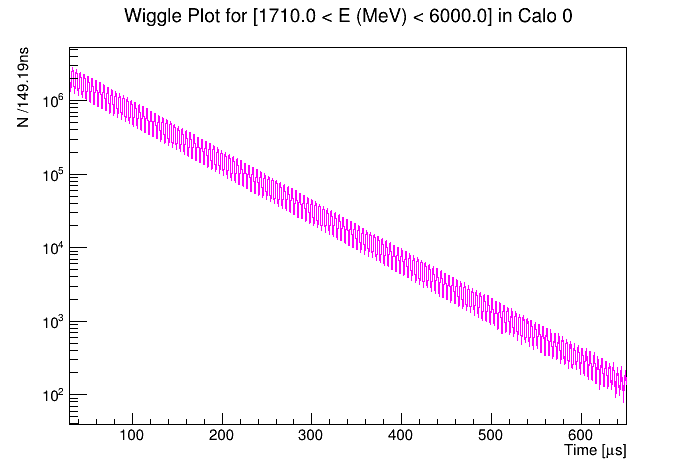

In [8]:
c = r.TCanvas()
wiggle.h.Draw()
c.SetLogy()
c.Draw()

In [9]:
fitFunc = WiggleFit(GetBlindingPhrase("./blinding.txt"), "5par")
#DumpClass(fitFunc)

 + ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ +
 +                                                                      +
 +           You have chose to blind your fitting according to          +
 +                omega_ref * (1 + (R +/- deltaR) *10^{-6})             +
 +                                                                      +
 + ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ +


In [10]:
fit = BuildTF1(fitFunc, 5, "5par", "five_parameter_fit", startTime, endTime)
fit.SetParameters([7000000,64.4,0.33,-33,0])
fit.SetParNames()

In [11]:
fitter = WiggleFitter(wiggle.h, fit, "5par", "REMB", 2)
fitter.Fit(2)

Starting fit 1 / 2
Parameters from this fit: 
     ChiSq/NDF =  10370.017391568037 / 4150 = 2.4987993714621775
      N  =  3453429.525439772 +/- 202.80407427071825
      #tau_{#mu}  =  64.27579927244359 +/- 0.0021234639712715228
      A  =  0.36920107772958227 +/- 4.379885872343334e-05
      R  =  -55.67673440753861 +/- 1.3357286027635127
      #phi_{a}  =  -1.05023756953525 +/- 0.00021933766762506277
Starting fit 2 / 2
Parameters from this fit: 
     ChiSq/NDF =  10370.017391568037 / 4150 = 2.4987993714621775
      N  =  3453429.525439772 +/- 202.80117969056755
      #tau_{#mu}  =  64.27579927244359 +/- 0.0021234292752797114
      A  =  0.36920107772958227 +/- 4.379885139362426e-05
      R  =  -55.67673440753861 +/- 1.3357256237097452
      #phi_{a}  =  -1.05023756953525 +/- 0.0002193373895449285
 FCN=10370 FROM MINOS     STATUS=SUCCESSFUL     36 CALLS         436 TOTAL
                     EDM=6.68722e-13    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                     

Warning in <TF1::AddToGlobalList>: Function is supposed to be in the global list but it is not present
Warning in <TF1::AddToGlobalList>: Function is supposed to be in the global list but it is not present


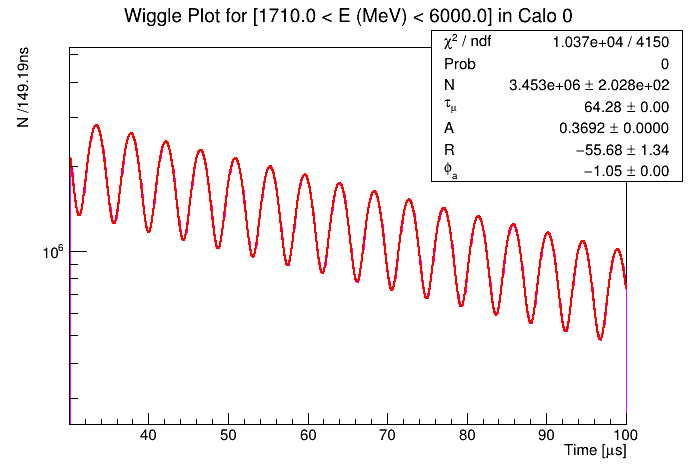

In [12]:
c = r.TCanvas()
fitter.h.Draw()
fitter.h.GetXaxis().SetRangeUser(28,100)
c.SetLogy()
c.Draw()

In [13]:
fitter.ComputeFFT()

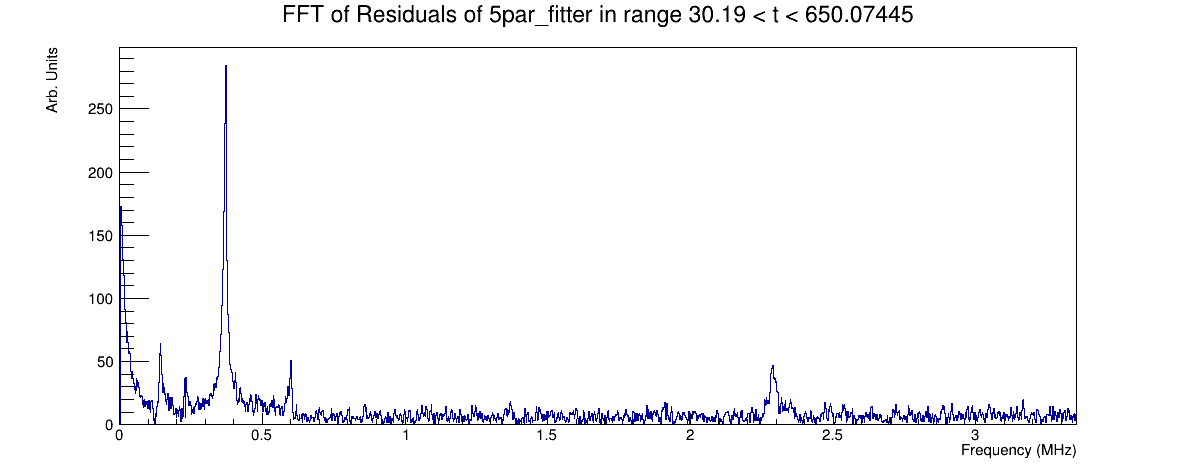

In [14]:
c = r.TCanvas("c","c",1200,500)
fitter.fft.Draw("hist")
#c.SetLogy()
c.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


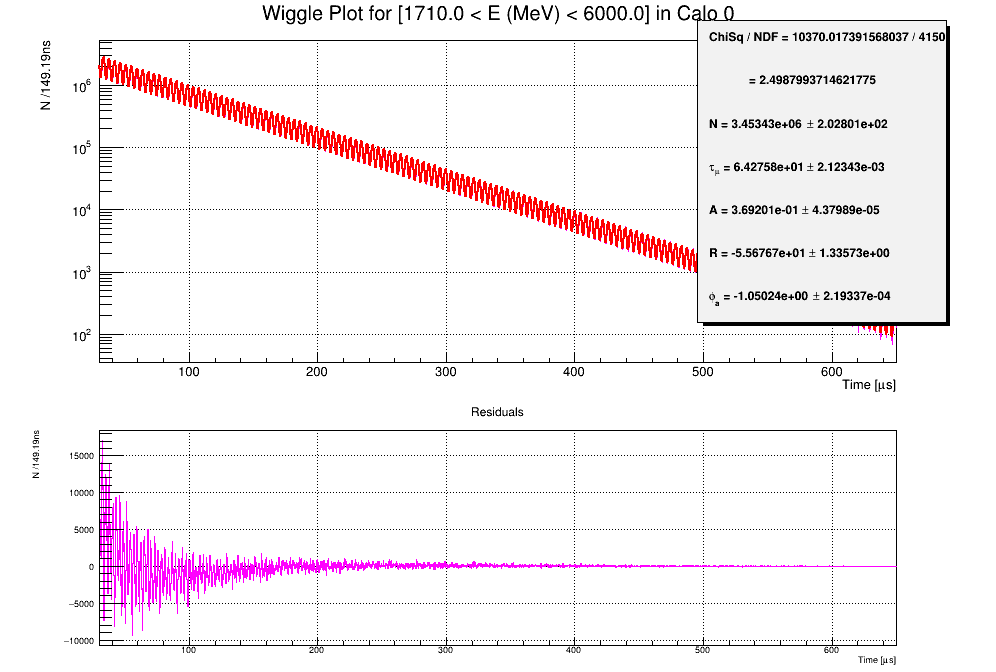

In [15]:
c = fitter.Draw()

In [16]:
outPaths = analyses[whichAnal][1].split("/")
outPath = ""
for x in outPaths:
    if("root" not in x):
        outPath+=x+"/"
print(outPath)
fitName = fitter.name
outFile = outPath+fitName
print(outFile)
SaveToRootFile(fitter, outFile)

./data/bingzhi/
./data/bingzhi/5par_fitter
Saving class <omega_a_fitting.WiggleFitter object at 0x7f82f2fd40f0>  to file  ./data/bingzhi/5par_fitter_2020_02_03_15_14_27.root
